In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import os
import logging
import scanpy as sc
import random

In [3]:
os.chdir("..")

In [ ]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)
#os.chdir("/scratch/sgoldman_lab/Projects_JNM/HD")
torch.cuda.get_device_name(0)

In [4]:
import numpy as np

In [5]:
import scvi as scvi

Global seed set to 0


In [6]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.12.1
logging==0.5.1.2
scanpy==1.7.2
numpy==1.21.5
scvi==0.14.5


In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=0
set_seed(seed)

Global seed set to 0


In [8]:
adata = sc.read_h5ad(
    "H5AD/HD_Competition_Preprocessed.h5ad")


In [9]:
adata.obs["SampleName"].unique()

array(['G19 EGFP Adult Alone Late 1', 'G19 EGFP Adult CtrlRescue 3',
       'G19 mCherry Adult Alone Late 7', 'G19 mCherry Adult Rescue 10',
       'G19 mCherry Adult Rescue 11', 'G19 mCherry Adult Rescue 9',
       'G19 mCherry Neonatal Alone Late 2',
       'G19 mCherry Neonatal CtrlRescue 3',
       'G20 EGFP Neonatal Alone Late 8', 'G20 EGFP Neonatal Rescue 10',
       'G20 EGFP Neonatal Rescue 11'], dtype=object)

In [10]:
adata

AnnData object with n_obs × n_vars = 10410 × 38743
    obs: 'SampleName', 'cellName', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'initialCell', 'initialFluor', 'initialTransplant', 'Paradigm', 'initialGroup', 'Capture', 'initialSampleName', 'EGFP_assign', 'mCherry_assign', 'zero_assign', 'EGFP', 'mCherry', 'Cell', 'Fluorophore', 'Transplant', 'Group'
    var: 'features'

In [11]:
non_fluoro = [name for name in adata.var_names if not name in ["EGFP","mCherry"]]

In [12]:
adata = adata[:,non_fluoro]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 10410 × 38741
    obs: 'SampleName', 'cellName', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'initialCell', 'initialFluor', 'initialTransplant', 'Paradigm', 'initialGroup', 'Capture', 'initialSampleName', 'EGFP_assign', 'mCherry_assign', 'zero_assign', 'EGFP', 'mCherry', 'Cell', 'Fluorophore', 'Transplant', 'Group'
    var: 'features'

In [14]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [15]:
### Currently used 5000
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="Group",
    span = .5, 
)

In [16]:
adata

AnnData object with n_obs × n_vars = 10410 × 4000
    obs: 'SampleName', 'cellName', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'initialCell', 'initialFluor', 'initialTransplant', 'Paradigm', 'initialGroup', 'Capture', 'initialSampleName', 'EGFP_assign', 'mCherry_assign', 'zero_assign', 'EGFP', 'mCherry', 'Cell', 'Fluorophore', 'Transplant', 'Group'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [17]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["Group", "SampleName", "Cell"],
    continuous_covariate_keys=["percent.mt", "nCount_RNA", "nFeature_RNA"]
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              


/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 10410 cells, 4000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 3 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [18]:
model = scvi.model.SCVI(adata)

In [19]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [ ]:
model.train(use_gpu=True)

In [ ]:
model

In [ ]:
model.save("H5AD/HD_Competition_SCVI_Model)


In [20]:
model = scvi.model.SCVI.load("H5AD/HD_Competition_SCVI_Model/", adata)

INFO     Using data from adata.layers["counts"]                                              


/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 10410 cells, 4000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 3 extra
         continuous covariates.                                                              


In [21]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [22]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [23]:
# 250.  Seed = 0
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 250, random_state=seed)


In [24]:
#spread = .5, min_dist = .6
sc.tl.umap(adata, spread = 0.5, min_dist = .6, random_state=seed)

/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'SampleName' as categorical
/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig.ident' as categorical
/scratch/sgoldman_lab/.conda/envs/scvi2/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is de

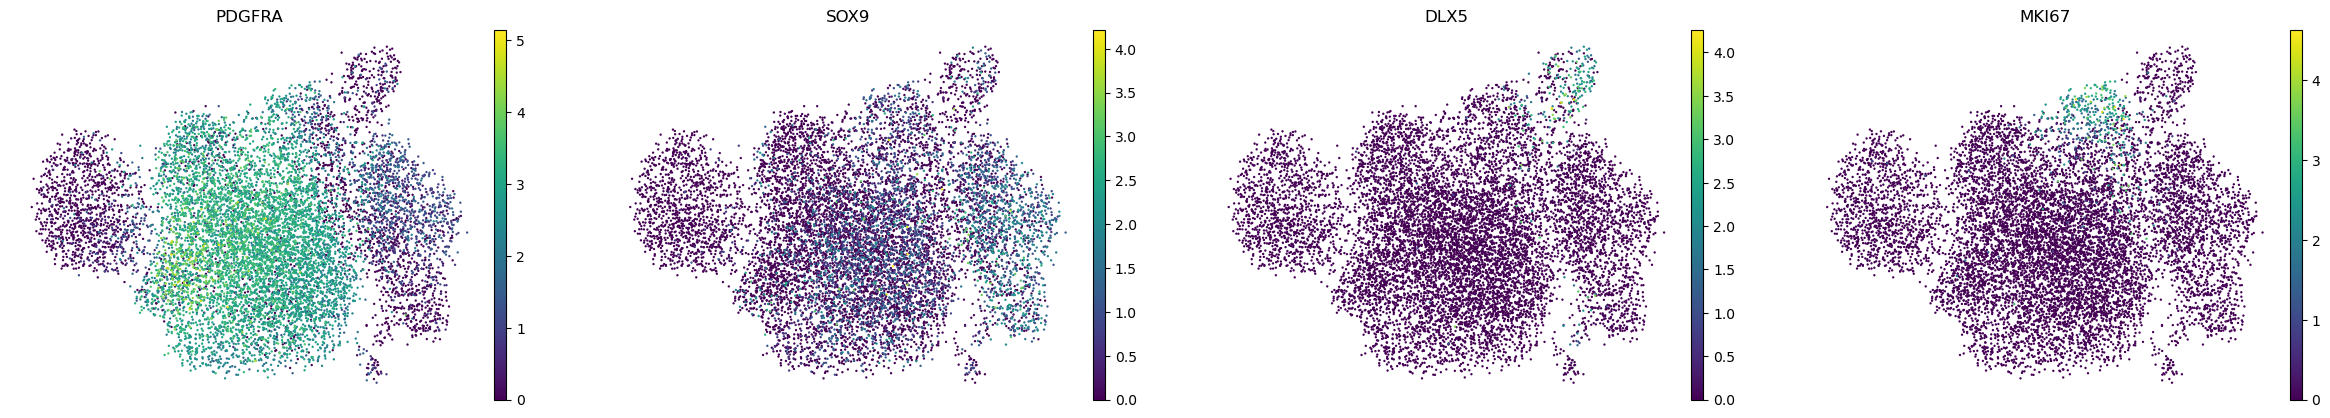

In [25]:
#1
sc.pl.umap(
    adata,
    color=["PDGFRA", "SOX9", "DLX5", "MKI67"],
    frameon=False
)

In [26]:
# .8
sc.tl.leiden(adata, key_added="leiden_scVI", resolution= .8)



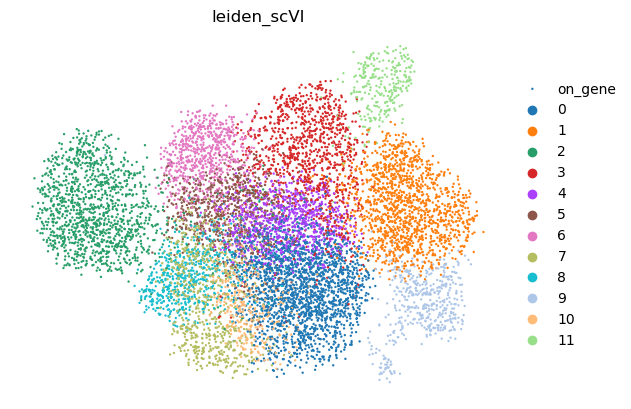

In [27]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
    label="on_gene"
)

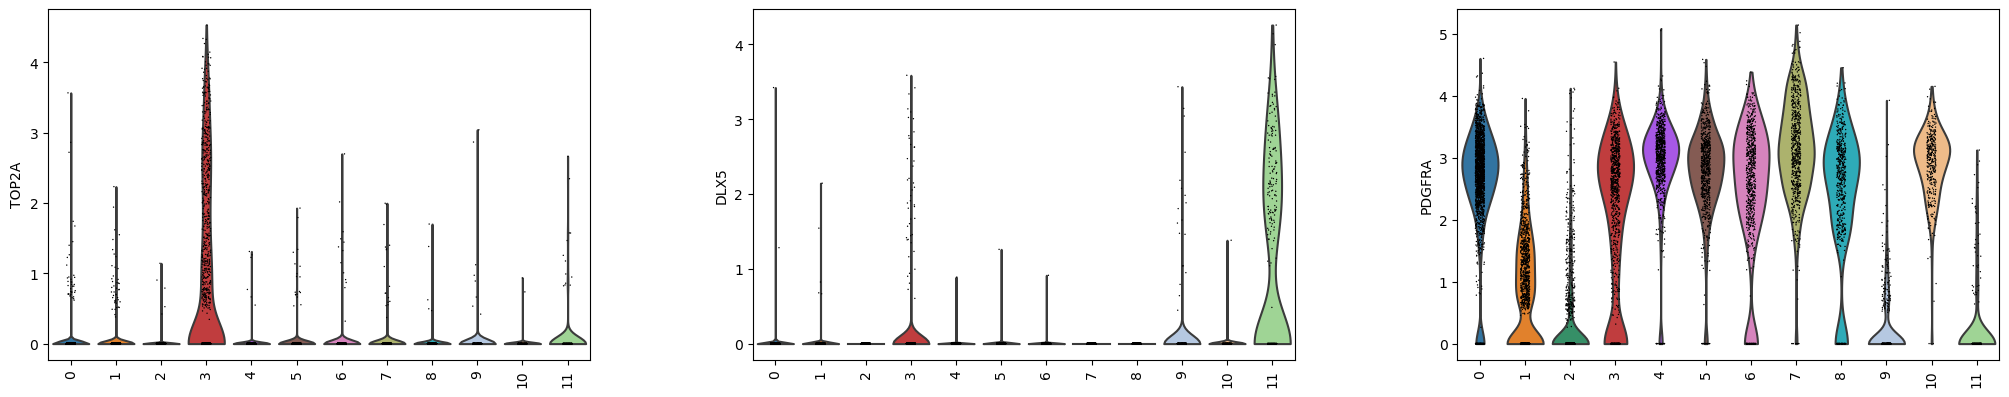

In [28]:
sc.pl.violin(adata, keys = ["TOP2A", "DLX5", "PDGFRA"], groupby="leiden_scVI", rotation = 90)

In [ ]:
adata.write("H5AD/HD_Competition_SCVI.h5ad")

In [ ]:
umapEmbeddings = adata.obsm["X_umap"]

In [ ]:
np.savetxt("data_for_import/umapEmbeddings", umapEmbeddings, delimiter=",")

In [ ]:
leiden_clusters = adata.obs["leiden_scVI"]

In [ ]:
type(leiden_clusters)

In [ ]:
adata.obs["leiden_scVI"].to_csv('data_for_import/leidenClusters.csv')
